All functions are delivered in the reactiv.py file

In [1]:
# replace here by the import of reactiv.py
from turtlesar.processing.sar.reactiv import *

In [2]:
import os
import sys
import glob
from glob import glob
import numpy as np
import rasterio
import rasterio.features
import rasterio.warp


import matplotlib.pyplot as plt
%matplotlib notebook

# DATA IMPORT  

In this section, we initialize the input data required for processing by the software. These data take the form of multi-dimensional arrays (ndarrays) from the Numpy library, specifically structured to represent time series from radar data.

Each time series is organized into a three-dimensional stack whose dimensions correspond to :

    Nt (temporal dimension): The total number of radar images in the series, equivalent to the number of acquisition dates available.
    Nx (Spatial dimension - X axis): The number of horizontal pixels in each radar image.
    Ny (Spatial dimension - Y axis): The number of vertical pixels in each radar image.

Thus, the stack structure is defined by Nt×Nx×NyNt×Nx×Ny.

Essential pre-processing: Before applying the software, it is crucial that these stacks are rigorously re-aligned to ensure precise spatial alignment between successive images. In the practical example proposed in this notebook, we use data stacks that have been pre-registered using GeFolki, a specific registration code.

The source data for the stacks comes from UAVSAR images over San Francisco, which are accessible as OpenSource data and are part of the "Single Look Complex" (SLC) product level.

Polarimetric channel organization: It is necessary to define a separate ndarray for each of the polarimetric channels available. If, for example, we have the polarimetric components HH, HV and VV, we'll need three separate Numpy arrays, each corresponding to one of these channels.


In [3]:
# Replace by our own data
Exx = np.load('/d/ekoenigu/DREAM/SanFrancisco/UAVSAR/SanFrancisco_xx.npy')
Exy = np.load('/d/ekoenigu/DREAM/SanFrancisco/UAVSAR/SanFrancisco_xy.npy')
Eyy = np.load('/d/ekoenigu/DREAM/SanFrancisco/UAVSAR/SanFrancisco_yy.npy')
print('Size of the Stack: ', 'xx:', np.shape(Exx),'xy:', np.shape(Exy),'yy:', np.shape(Eyy), )

Size of the Stack:  xx: (12, 400, 1000) xy: (12, 400, 1000) yy: (12, 400, 1000)


In [4]:
Nt,nx,ny=np.shape(Exx)

## Test on amplitudes

 Here we define the stack for each polarimetric channel in intensities

In [5]:
p0=np.abs(Exx)**2
p1=np.abs(Exy)**2
p2=np.abs(Eyy)**2
P3=[p0,p1,p2]
p=len(P3)

We compute each individual coefficient of variations, one by polarimetric channel

In [6]:
CVHH=Stack2SingleCV(p0,timeaxis=0)
CVHV=Stack2SingleCV(p1,timeaxis=0)
CVVV=Stack2SingleCV(p2,timeaxis=0)

In [7]:
Lmin3,Lmax3=CV_Generalized_Limits(P3)

100%|██████████████████████████████████████████████████████████████| 400/400 [00:58<00:00,  6.84it/s]


In [8]:
def renormalize_matrix(M,p1,p2):
    """
    Renormalize the values of a matrix between 0 and 1, where 0 corresponds to the 1st percentile
    and 1 corresponds to the 99th percentile.

    Parameters:
    - M: Input matrix.

    Returns:
    - M_normalized: Renormalized matrix.
    """
    # Calcul des percentiles 1 et 99
    percentile_1 = np.percentile(M, p1)
    percentile_2 = np.percentile(M, p2)

    # Renormalisation entre 0 et 1
    M_normalized = (M - percentile_1) / (percentile_2 - percentile_1)

    # Assurer que les valeurs sont limitées entre 0 et 1 (au cas où)
    M_normalized = np.clip(M_normalized, 0, 1)

    return M_normalized

<IPython.core.display.Javascript object>


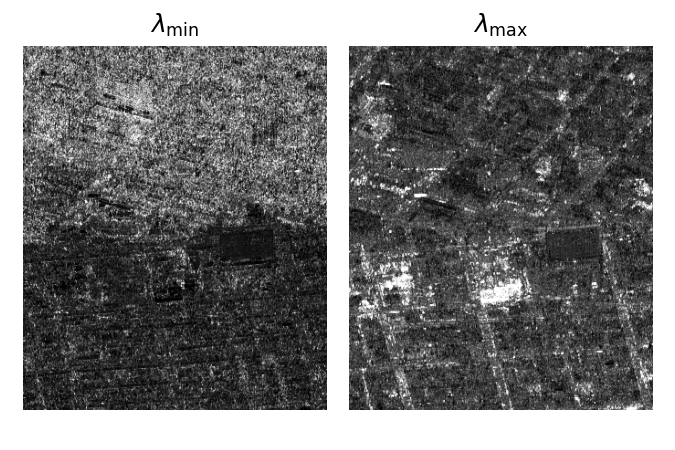

In [9]:
import cv2
fig, axs = plt.subplots(1, 2, figsize=(4.5, 3))
p1=1
p2=98
axs[0].imshow(cv2.resize(renormalize_matrix(Lmin3,p1,p2),(ny//3,nx), interpolation=cv2.INTER_AREA),cmap='gray')
axs[0].set_title('$\lambda_{{\min}}$')
axs[0].axis('off')
axs[1].imshow(cv2.resize(renormalize_matrix(Lmax3,p1,p2),(ny//3,nx), interpolation=cv2.INTER_AREA),cmap='gray')
axs[1].set_title('$\lambda_{{\max}}$')
axs[1].axis('off')
plt.tight_layout()

Compute classical coefficients of variation

In [10]:
CVRR, CVgv, CVVN, CVAZ =CV_fromListofImages(P3)

Compute intermediate MCV (Multivariate Coefficients of variation)

In [ ]:
CV1=CV_Generalized_equally(P3,1)  # you can check CVgv = CV1   CV0 = CVRR 
CVne1=CV_Generalized_Non_equally(P3,1)  # you can check CVne1 = CVAZ
CVnemoins1=CV_Generalized_Non_equally(P3,-1) # you can check CVne-1 = CVVN
CV_ne0=CV_Generalized_Non_equally_Zero(P3)


# Comparison Jones Amplitudes and Stokes

In [15]:
def Jones2Stokes(Ex, Ey):
    """
    Convert Jones vectors to Stokes parameters.
    Args:
        Ex (numpy.ndarray): Electric field component in the x-direction over time and space.
                           Dimensions: (nt, nx, ny)
        Ey (numpy.ndarray): Electric field component in the y-direction over time and space.
                           Dimensions: (nt, nx, ny)
    Returns:
        tuple: A tuple containing four matrices representing the Stokes parameters:
            - S0 (numpy.ndarray): Total intensity. Dimensions: (nt, nx, ny)
            - S1 (numpy.ndarray): Stokes parameter S1. Dimensions: (nt, nx, ny)
            - S2 (numpy.ndarray): Stokes parameter S2. Dimensions: (nt, nx, ny)
            - S3 (numpy.ndarray): Stokes parameter S3. Dimensions: (nt, nx, ny)
    """
    # Calculate Stokes parameters
    S0 = np.abs(Ex)**2 + np.abs(Ey)**2
    S1 = np.abs(Ex)**2 - np.abs(Ey)**2
    S2 = 2 * np.real(Ex * np.conj(Ey))
    S3 = 2 * np.imag(Ex * np.conj(Ey))

    return S0, S1, S2, S3

def Stokes2Intensities(S0,S1,S2,S3):
    """
    Convert Stokes parameters into positive intensities.
    Args:
        Si (numpy.ndarray): Stokes components   Dimensions: (nt, nx, ny)
    Returns:
        tuple: A tuple containing four matrices representing the Intensities parameters:
            - Ii (numpy.ndarray): Positive Intensity. Dimensions: (nt, nx, ny)

    """
    # Calculate Stokes parameters
    I0=S0+1/np.sqrt(3)*S1+1/np.sqrt(3)*S2+1/np.sqrt(3)*S3
    I1=S0+1/np.sqrt(3)*S1-1/np.sqrt(3)*S2-1/np.sqrt(3)*S3
    I2=S0-1/np.sqrt(3)*S1-1/np.sqrt(3)*S2+1/np.sqrt(3)*S3
    I3=S0-1/np.sqrt(3)*S1+1/np.sqrt(3)*S2-1/np.sqrt(3)*S3

    return I0, I1, I2, I3

S0, S1, S2, S3=Jones2Stokes(Exx,Exy)
I0, I1, I2, I3=Stokes2Intensities(S0, S1,S2,S3)


In [12]:
P=[I0,I1,I2,I3]

100%|██████████████████████████████████████████████████████████████| 400/400 [01:27<00:00,  4.58it/s]


<IPython.core.display.Javascript object>


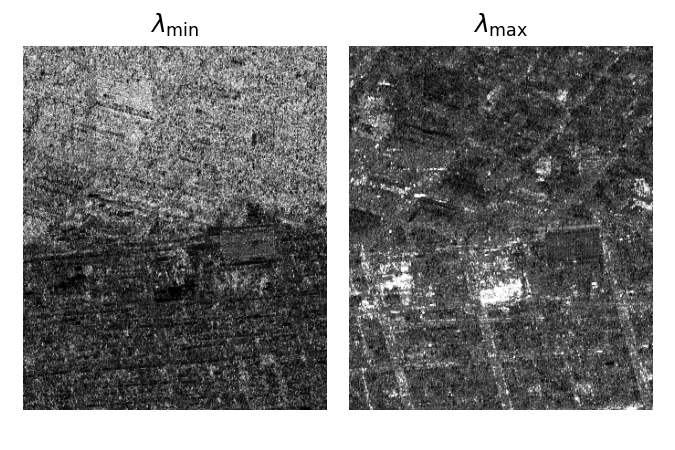

In [13]:
Lmin,Lmax=CV_Generalized_Limits(P)
fig, axs = plt.subplots(1, 2, figsize=(4.5, 3))
p1=1
p2=98
axs[0].imshow(cv2.resize(renormalize_matrix(Lmin,p1,p2),(ny//3,nx), interpolation=cv2.INTER_AREA),cmap='gray')
axs[0].set_title('$\lambda_{{\min}}$')
axs[0].axis('off')
axs[1].imshow(cv2.resize(renormalize_matrix(Lmax,p1,p2),(ny//3,nx), interpolation=cv2.INTER_AREA),cmap='gray')
axs[1].set_title('$\lambda_{{\max}}$')
axs[1].axis('off')
plt.tight_layout()

In [14]:
p0=np.abs(Exx)**2
p1=np.abs(Exy)**2
P2=[p0,p1]
Lmin2,Lmax2=CV_Generalized_Limits(P2)

100%|██████████████████████████████████████████████████████████████| 400/400 [00:56<00:00,  7.12it/s]


<IPython.core.display.Javascript object>


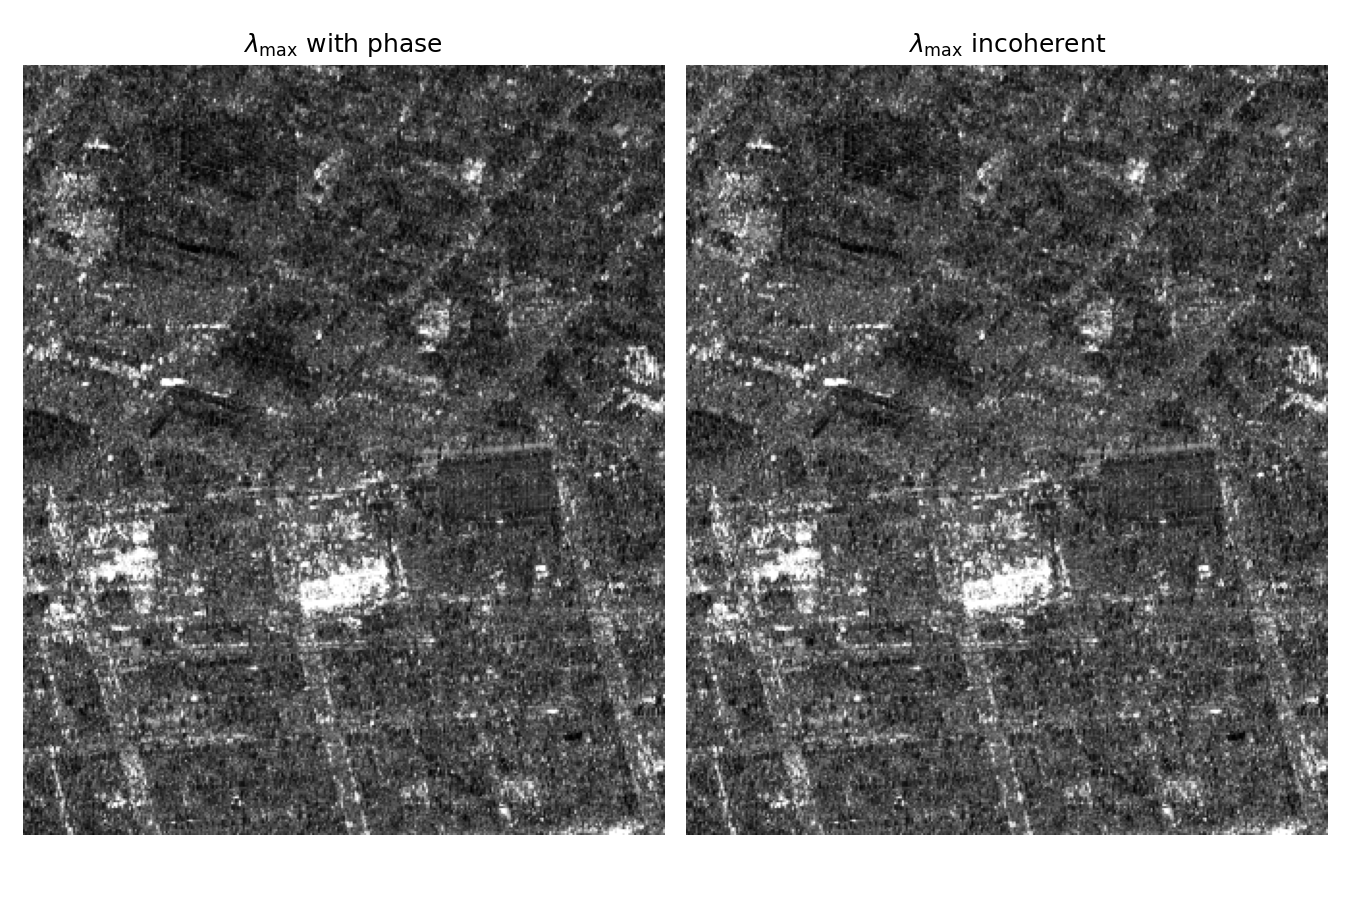

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(9, 6))
p1=1
p2=98
axs[0].imshow(cv2.resize(renormalize_matrix(Lmax,p1,p2),(ny//3,nx), interpolation=cv2.INTER_AREA),cmap='gray')
axs[0].set_title('$\lambda_{{\max}}$ with phase')
axs[0].axis('off')
axs[1].imshow(cv2.resize(renormalize_matrix(Lmax2,p1,p2),(ny//3,nx), interpolation=cv2.INTER_AREA),cmap='gray')
axs[1].set_title('$\lambda_{{\max}}$ incoherent')
axs[1].axis('off')
plt.tight_layout()

# Analyzis for one pixel

In [17]:
def Analyse_matrixC(P,x,y):
    p=len(P)
    Nt=P[0].shape[0]
    pixel_series = np.array([[P[i][t, x, y] for t in range(Nt)] for i in range(p)])
    # Calculate the covariance matrix for this pixel series
    C = np.cov(pixel_series)*(Nt-1)/Nt
    mu=np.mean(pixel_series,axis=1)
    normMU=np.linalg.norm(mu)
    valeurs_propres, vecteurs_propres = np.linalg.eig(C)

    print('matrice C: ', C/np.trace(C))
    print('valeurs propres normalisees', valeurs_propres/np.trace(C))
    print('vecteurs propres ', vecteurs_propres)

    plt.figure()
    for i in range(len(pixel_series)):
        plt.plot(pixel_series[i], 'o',linestyle='--',markersize=4, label=f'Canal {i+1}')
    plt.legend()
    
    NQ=30
    CVeq=tableau = [0] * (2*NQ+1)
    CVne=tableau = [0] * (2*NQ+1)

    for k,Q in enumerate(range(-NQ,NQ+1)):
        if Q!=0:
            CQ=np.linalg.matrix_power(C, Q) # COvariance Matrix power Q
            toto=np.sqrt((1/p*np.trace(CQ))**(1/Q))/normMU
            CVeq[k]=np.sqrt((1/p*np.trace(CQ))**(1/Q))/normMU
        
            mu=np.mean(pixel_series,axis=1)
            normMU=np.linalg.norm(mu)
            intermediate_result = np.dot(mu.T, CQ)
            result = np.dot(intermediate_result, mu)
            CVne[k]=np.sqrt((1/1*result)**(1/Q))/normMU**(1+1/Q)
        else:
            CVeq[k]=np.sqrt(np.linalg.det(C)**(1/p))/normMU
            mu=np.mean(pixel_series,axis=1)
            normMU=np.linalg.norm(mu)
            eigenvalues,U= np.linalg.eig(C)
            muprime=np.dot(U.T,mu)
            result=(np.prod(eigenvalues**(np.abs(muprime)**2)))**(1/normMU**2)
            CVne[k]=np.sqrt(result)/normMU
    plt.figure()
    plt.plot(range(-NQ,NQ+1),CVeq,color='k')
    plt.plot(range(-NQ,NQ+1),CVne,color='gray')
    plt.axhline(y=np.sqrt(np.max(valeurs_propres))/normMU, color='r', linestyle='-')
    plt.axhline(y=np.sqrt(np.min(valeurs_propres))/normMU, color='b', linestyle='-')
    plt.plot(0, CVeq[NQ], 'o', markersize=8,color='k')
    plt.plot(1, CVeq[NQ+1], 'o', markersize=8,color='k')
    plt.plot(1, CVne[NQ+1], 'o', markersize=8,color='gray')
    plt.plot(0, CVne[NQ], 'o', markersize=8,color='gray')
    plt.plot(-1, CVne[NQ-1], 'o', markersize=8,color='gray')


matrice C:  [[ 0.24609264  0.29557875  0.21135909 -0.00330939]
 [ 0.29557875  0.48330973  0.30347752  0.01666958]
 [ 0.21135909  0.30347752  0.25135878 -0.01956695]
 [-0.00330939  0.01666958 -0.01956695  0.01923885]]
valeurs propres normalisees [0.89549329 0.06155713 0.04019546 0.00275412]
vecteurs propres  [[ 4.88267264e-01  3.05421668e-01  8.17459859e-01  8.48890922e-03]
 [ 7.16737336e-01 -5.88592504e-01 -2.04946022e-01 -3.12799591e-01]
 [ 4.97877713e-01  5.48491538e-01 -5.06888293e-01  4.40839057e-01]
 [ 6.73200583e-04 -5.09346151e-01  1.81165023e-01  8.41275983e-01]]


<IPython.core.display.Javascript object>


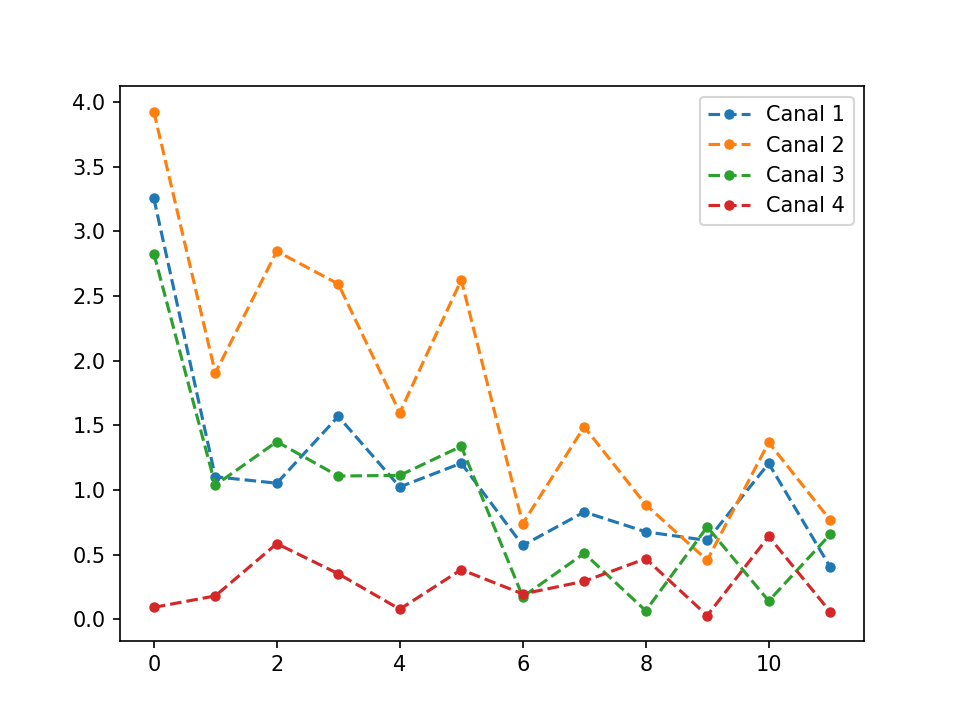

<IPython.core.display.Javascript object>


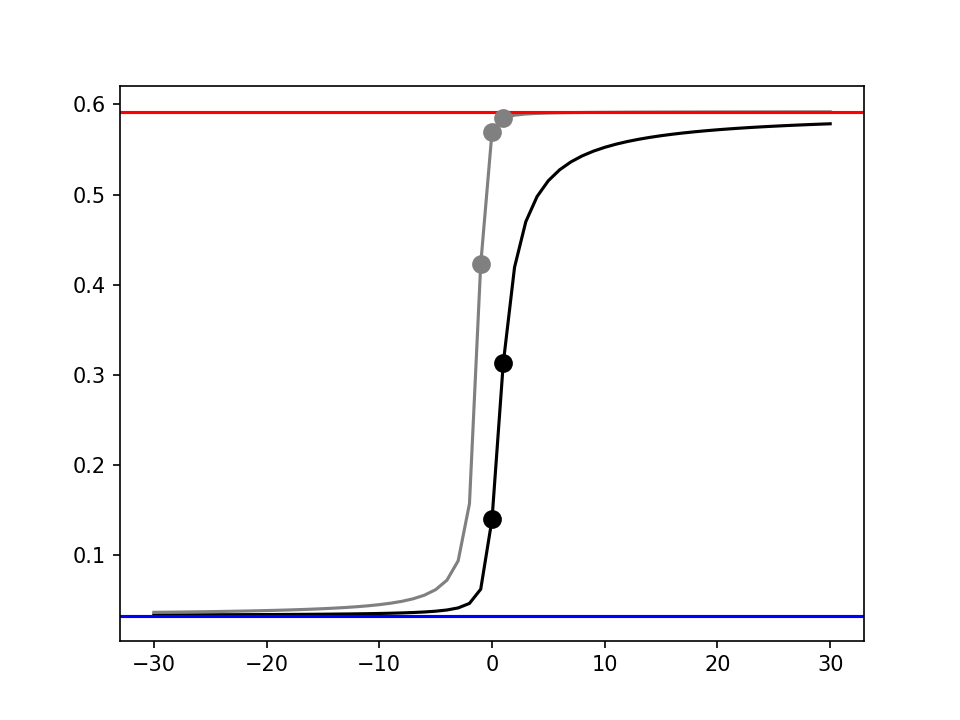

In [18]:
Analyse_matrixC(P,103,761)

## Analysis of profiles in Pauli basis

In [19]:
def PlotProfilesPauli(P,x,y):
    p=len(P)
    Nt=P[0].shape[0]
    pixel_series = np.array([[P[i][t, x, y] for t in range(Nt)] for i in range(p)])
    
    plt.rcParams['font.size'] = 14 # Taille de police globale
    plt.rcParams['axes.labelsize'] = 14 # Taille de police pour les labels des axes
    plt.rcParams['axes.titlesize'] = 16 # Taille de police pour les titres
    plt.rcParams['xtick.labelsize'] = 14 # Taille de police pour les labels des ticks sur l'axe des x
    plt.rcParams['ytick.labelsize'] = 14 # Taille de police pour les labels des ticks sur l'axe des y
    plt.rcParams['legend.fontsize'] = 14 # Taille de police pour la légende


    plt.figure()
    plt.plot(pixel_series[0], 'o',linestyle='--',color='b',markersize=6, label=f'Intensity Profile: HH-VV')
    plt.plot(pixel_series[1], 'x',linestyle='--',color='g',markersize=6, label=f'Intensity Profile: 2 HV')
    plt.plot(pixel_series[2], 's',linestyle='--',color='r',markersize=6, label=f'Intensity Profile: HH+VV')
    plt.title('$\lambda_{\min}$'+'={:.2f}'.format(Lmin3[x,y])+'$~~  \lambda_{\max}$'+'={:.2f}'.format(Lmax3[x,y]))
    plt.xlabel('Number of Acquisition')
    plt.legend()
    #plt.savefig('ex103.png', dpi=300)

In [20]:
p0=np.abs(Exx-Eyy)**2
p1=np.abs(2*Exy)**2
p2=np.abs(Exx+Eyy)**2
P3=[p0,p1,p2]

Lmin3,Lmax3=CV_Generalized_Limits(P3)

100%|██████████████████████████████████████████████████████████████| 400/400 [00:58<00:00,  6.83it/s]


In [21]:
# To find specific behaviors
# indices = np.where((Lmin3<0.001)*(Lmax3>1))
# print("Indices", indices)
# Case Lmin low: 264 538, 263 128, 279 469
# Lmax high Lmin high 141 264, 79 991, 263 520

<IPython.core.display.Javascript object>


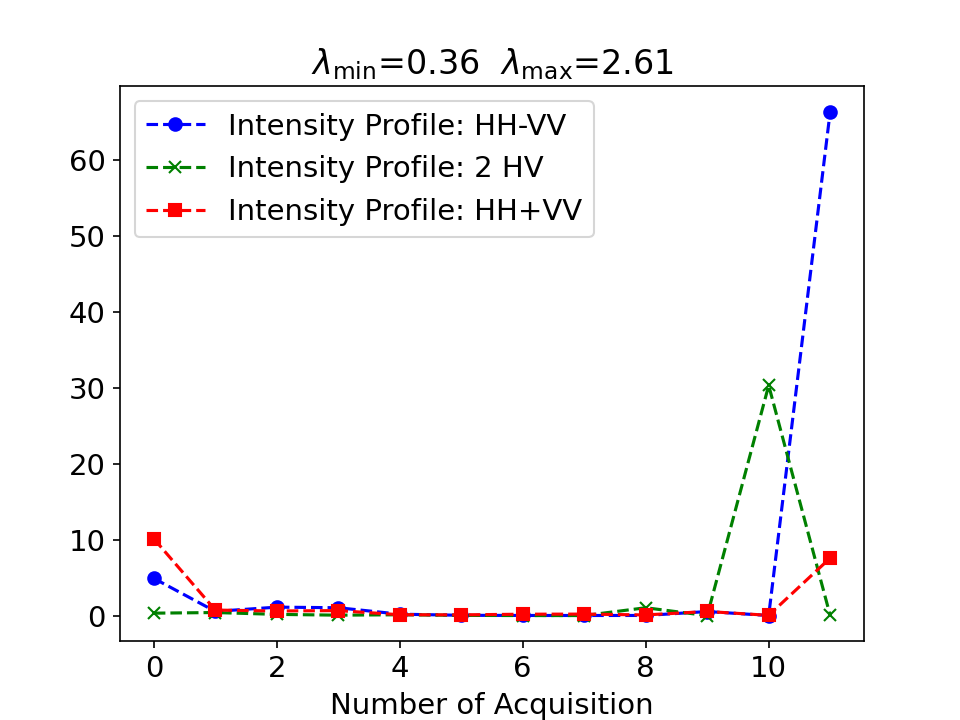

In [22]:
PlotProfilesPauli(P3,263,520)